# DMI API Tutorial

```{post} 2022-02-22
:tags: open science
:author: Adam R. Jensen
:image: 1
```

This tutorial gives an introduction on how to use the [Danish Meteorological Institute's (DMI) API](https://confluence.govcloud.dk/display/FDAPI) to download meterological observation data (v2).

The tutorial uses the Python programming language and is in the format of a Jupyter Notebook. The notebook can be downloaded and run locally, allowing you to quickly get started downloading data.


If you're new to the DMI observation data, I recommend that you check out some of the following links:
1. [Parameters](https://confluence.govcloud.dk/display/FDAPI/Meteorological+Observation+Data)
2. [Stations](https://confluence.govcloud.dk/display/FDAPI/Meteorological+Observation+Data+Stations)
3. [Station availability](https://confluence.govcloud.dk/display/FDAPI/Meteorological+Observation+Data+Stations+Historical+Availability?src=contextnavpagetreemode)
4. [FAQ](https://confluence.govcloud.dk/display/FDAPI/FAQ)
5. [Terms of use](https://confluence.govcloud.dk/display/FDAPI/Terms+of+Use)
6. [Operational status](https://statuspage.freshping.io/25721-DMIOpenDatas)
7. [User creation](https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476690)

<br>

A map of the active DMI stations is shown below:

In [1]:
import pandas as pd
station_url = 'https://confluence.govcloud.dk/display/FDAPI/Meteorological+Observation+Data+Stations'

stations = pd.read_html(station_url, header=[0])[0]

stations = stations[stations['status'] == 'Active']
# This line removes previous locations of the same station
# thus only the newest/current location is shown
stations = stations[stations['validTo'].isna()]

# stations.reset_index()

In [3]:
import folium
from folium import plugins

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[75, -5],
    zoom_start=2, min_zoom=2, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)


# Add each station to the map
for index, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        popup=f"Station ID: {row['stationId']}\n{row['name']}, {row['country']}",
        tooltip=f"{row['name']}, {row['country']}",
        radius=5, color='blue',
        fill_color='blue', fill=True).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution).add_to(m)
folium.LayerControl(position='topright').add_to(m)

# Additional options and plugins
plugins.Fullscreen(position='bottomright').add_to(m)  # Add full screen button to map
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map

# Show the map
m

## Part 1: Retrieving data
Part 1 of this tutorial will show how to request data and convert it to a table format. Part 2 will deal with how to request specific data and more advanced data handling.

First, the necessary libraries have to be imported:

In [4]:
import requests # library for making HTTP requests
import pandas as pd # library for data analysis
import datetime as dt # library for handling date and time objects

<br>

In order to access the API it is necessary to create a user and obtain an api-key. This api-key grants permission to retrieve data and allows DMI to generate usage statistics.

A guide to creating a user profile and getting an api-key can be found [here](https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476690).



In [5]:
api_key = 'xxxxxxxx-yyyy-zzzz-iiii-jjjjjjjjjjjj' # insert your own key between the '' signs

In [6]:
# Delete this cell if you run the notebook locally
import os
api_key = os.environ["DMI_API_KEY"]

An easy test to see if your api-key works is to paste the following url into your browswer followed by a question mark and your api-key, e.g.: [https://dmigw.govcloud.dk/metObs/v1/observation?api-key=xxxxxxxx-yyyy-zzzz-iiii-jjjjjjjjjjjj](https://dmigw.govcloud.dk/metObs/v1/observation?api-key=xxxxxxxx-yyyy-zzzz-iiii-jjjjjjjjjjjj) (the example API key error).

If you have obtained an api-key and pasted it correctly, a page with data will be shown.
<br><br>

In the following code block, data is retrieved using the ``requests.get`` function. Further information on REST APIs and HTTP request methods can be found [here](https://restfulapi.net/http-methods/).


In [17]:
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
r = requests.get(DMI_URL, params={'api-key': api_key}) # Issues a HTTP GET request
print(r)

<Response [200]>


<br/>

The [response status code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) indicates whether the request was successful or not. A 200 code means that the retrieval was successful. 
<br/><br/>


Next, we extract the JSON file containing the data from the returned request object. [JSON](https://restfulapi.net/introduction-to-json/) is a human-readable format for data exchange.


In [8]:
json = r.json()  # Extract JSON data
print(json.keys())  # Print the keys of the JSON dictionary

dict_keys(['type', 'features', 'timeStamp', 'numberReturned', 'links'])


<br/>
When inspecting the json object, it can be noticed that the measurement data is contained within the features:

In [9]:
json['features'][:2]

[{'geometry': {'coordinates': [8.0828, 55.5575], 'type': 'Point'},
  'id': '00000001-30ad-ae74-5b33-7ef0a1a6ef92',
  'type': 'Feature',
  'properties': {'created': '2023-07-08T04:22:44.246708Z',
   'observed': '2015-09-11T10:10:00Z',
   'parameterId': 'temp_dew',
   'stationId': '06081',
   'value': 11.4}},
 {'geometry': {'coordinates': [11.3879, 55.3224], 'type': 'Point'},
  'id': '00000005-79f9-4ab8-6905-bec39ce37f54',
  'type': 'Feature',
  'properties': {'created': '2023-07-07T12:46:35.469876Z',
   'observed': '2010-08-10T03:30:00Z',
   'parameterId': 'humidity',
   'stationId': '06135',
   'value': 100.0}}]

<br/>

The JSON object can be converted to a convenient table (pandas DataFrame) using ``pd.json_normalize``:

In [10]:
df = pd.json_normalize(json['features'])  # Convert JSON object to a Pandas DataFrame
df.head()  # Print the first five rows of the DataFrame

,id,type,geometry.coordinates,geometry.type,properties.created,properties.observed,properties.parameterId,properties.stationId,properties.value,geometry
0,00000001-30ad-ae74-5b33-7ef0a1a6ef92,Feature,"[8.0828, 55.5575]",Point,2023-07-08T04:22:44.246708Z,2015-09-11T10:10:00Z,temp_dew,06081,11.4,NaN
1,00000005-79f9-4ab8-6905-bec39ce37f54,Feature,"[11.3879, 55.3224]",Point,2023-07-07T12:46:35.469876Z,2010-08-10T03:30:00Z,humidity,06135,100.0,NaN
2,00000006-ffbe-6f2f-fe2a-4ed40a6fa65a,Feature,NaN,NaN,2023-07-08T10:03:52.695118Z,1960-12-16T06:00:00Z,cloud_cover,06190,100.0,NaN
3,0000000e-638e-5ce8-2dab-0a16387eb3e9,Feature,"[8.6705, 56.383]",Point,2023-07-08T00:17:49.896354Z,2005-08-22T06:00:00Z,temp_max_past12h,06056,16.6,NaN
4,0000000e-fa0d-c953-0901-0856867a22bb,Feature,"[11.6035, 55.7358]",Point,2023-07-07T14:01:51.083752Z,2014-04-08T17:10:00Z,pressure_at_sea,06156,1006.3,NaN


<br/>

The timestamps strings can be converted to a datetime object using the pandas ``to_datetime`` function.

In [11]:
df['time'] = pd.to_datetime(df['properties.observed'])
df['time'].head()  # Print the first five timestamps

0   2015-09-11 10:10:00+00:00
1   2010-08-10 03:30:00+00:00
2   1960-12-16 06:00:00+00:00
3   2005-08-22 06:00:00+00:00
4   2014-04-08 17:10:00+00:00
Name: time, dtype: datetime64[ns, UTC]

<br/>
Last, we will generate a list of all the available parameters:

In [12]:
parameter_ids = df['properties.parameterId'].unique()  # Generate a list of unique parameter ids
print(parameter_ids)  # Print all unique parameter ids

['temp_dew' 'humidity' 'cloud_cover' 'temp_max_past12h' 'pressure_at_sea'
 'wind_speed' 'temp_soil_max_past1h' 'weather' 'wind_dir' 'temp_dry'
 'precip_dur_past10min' 'temp_grass' 'leav_hum_dur_past10min'
 'temp_min_past1h' 'precip_past1min' 'precip_past1h' 'pressure'
 'radia_glob' 'wind_speed_past1h' 'humidity_past1h' 'sun_last10min_glob'
 'precip_past10min' 'visib_mean_last10min' 'leav_hum_dur_past1h'
 'visibility' 'temp_soil' 'temp_soil_min_past1h' 'wind_min'
 'temp_grass_min_past1h' 'wind_min_past1h' 'cloud_height'
 'temp_min_past12h' 'wind_max_per10min_past1h' 'temp_max_past1h'
 'temp_soil_mean_past1h' 'wind_max' 'wind_dir_past1h' 'radia_glob_past1h'
 'temp_grass_mean_past1h' 'precip_dur_past1h' 'wind_gust_always_past1h'
 'sun_last1h_glob' 'temp_mean_past1h' 'temp_grass_max_past1h'
 'snow_depth_man']


<br/><br/>

## Part 2: Requesting specific data

The above example was a heavily simplied example to illustrate how the API can be accessed. For most applications you probably want to specify query criterias, such as:
1. Meterological stations (e.g. 04320, 06074, etc.)
2. Parameters (e.g. wind_speed, humidity, etc.)
3. Time frame (to and from time)
4. Limit (maximum number of observations)

*Click the "View to show" button below to see a list of a all stations and parameters.*

In [13]:
all_stations = [
    '04203', '04208', '04214', '04220', '04228', '04242', '04250',
    '04253', '04266', '04271', '04272', '04285', '04301', '04312',
    '04313', '04320', '04330', '04339', '04351', '04360', '04373',
    '04382', '04390', '05005', '05009', '05015', '05031', '05035',
    '05042', '05065', '05070', '05075', '05081', '05085', '05089',
    '05095', '05105', '05109', '05135', '05140', '05150', '05160',
    '05165', '05169', '05185', '05199', '05202', '05205', '05220',
    '05225', '05269', '05272', '05276', '05277', '05290', '05296',
    '05300', '05305', '05320', '05329', '05343', '05345', '05350',
    '05355', '05365', '05375', '05381', '05395', '05400', '05406',
    '05408', '05435', '05440', '05450', '05455', '05469', '05499',
    '05505', '05510', '05529', '05537', '05545', '05575', '05735',
    '05880', '05889', '05935', '05945', '05970', '05986', '05994',
    '06019', '06031', '06032', '06041', '06049', '06051', '06052',
    '06056', '06058', '06065', '06068', '06072', '06073', '06074',
    '06079', '06081', '06082', '06088', '06093', '06096', '06102',
    '06116', '06119', '06123', '06124', '06126', '06132', '06135',
    '06136', '06138', '06141', '06147', '06149', '06151', '06154',
    '06156', '06159', '06168', '06169', '06174', '06181', '06183',
    '06184', '06186', '06187', '06188', '06193', '06197', '20000',
    '20030', '20055', '20085', '20228', '20279', '20315', '20375',
    '20400', '20552', '20561', '20600', '20670', '21020', '21080',
    '21100', '21120', '21160', '21208', '21368', '21430', '22020',
    '22080', '22162', '22189', '22232', '22410', '23100', '23133',
    '23160', '23327', '23360', '24043', '24102', '24142', '24171',
    '24380', '24430', '24490', '25045', '25161', '25270', '25339',
    '26210', '26340', '26358', '26450', '27008', '27082', '28032',
    '28110', '28240', '28280', '28385', '28552', '28590', '29020',
    '29194', '29243', '29330', '29440', '30075', '30187', '30215',
    '30414', '31040', '31185', '31199', '31259', '31350', '31400',
    '31509', '31570', '32110', '32175', '34270', '34320', '34339'
]

all_parameters = [
    # Cloud cover and height
    'cloud_cover', 'cloud_height',
    # Humdity
    'humidity', 'humidity_past1h',
    # Precipitation
    'precip_past10min', 'precip_past1h', 'precip_past24h',
    # Pressure
    'pressure', 'pressure_at_sea',
    # Radiation
    'radia_glob', 'radia_glob_past1h',
    # Temperature
    'temp_dew', 'temp_dry', 'temp_max_past12h', 'temp_max_past1h',
    'temp_mean_past1h', 'temp_min_past12h', 'temp_min_past1h',
    # Visibilty and weather
    'visib_mean_last10min', 'visibility', 'weather',
    # Wind speed and direction
    'wind_dir', 'wind_dir_past1h', 'wind_gust_always_past1h', 'wind_max',
    'wind_max_per10min_past1h', 'wind_min', 'wind_min_past1h',
    'wind_speed', 'wind_speed_past1h',
]

<br>

Due to poor design of the API, it is only possible to request one station or all stations, and similarly, it is only possible to request one parameter or all parameters. To be able to select a subset of stations or parameters it is therefore necessary to loop as shown below. This also avoids hitting the rather low maximum amount of data that can be transferred for each request. The implementation below is most suitable for downloading a few stations and a few parameters, and will incur a significant performance penalty if downloading data for all stations.

In [14]:
# Specify the desired start and end time
start_time = pd.Timestamp(2022, 1, 1)
end_time = pd.Timestamp(2022, 1, 15)

# Specify one or more station IDs or all_stations
stationIds = ['04250', '06188']
# Specify one or more parameter IDs or all_parameters
parameterIds = ['radia_glob', 'wind_speed']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

dfs = []
for station in stationIds:
    for parameter in parameterIds:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            # Drop other columns
            dfi = dfi[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
            # Rename columns, e.g., 'properties.stationId' becomes 'stationId'
            dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
            # Drop identical rows (considers both value and time stamp)
            dfi = dfi[~dfi.duplicated()]
            dfi = dfi.set_index(['parameterId', 'stationId', 'time'])
            dfi = dfi['value'].unstack(['stationId','parameterId'])
            dfs.append(dfi)

df = pd.concat(dfs, axis='columns').sort_index()
df.head()

stationId                      04250                 06188           
parameterId               radia_glob wind_speed radia_glob wind_speed
time                                                                 
2022-01-01 00:00:00+00:00        0.0        3.6        0.0        4.9
2022-01-01 00:10:00+00:00        0.0        4.0        0.0        5.5
2022-01-01 00:20:00+00:00        0.0        3.8        0.0        4.8
2022-01-01 00:30:00+00:00        0.0        3.8        0.0        5.3
2022-01-01 00:40:00+00:00        0.0        3.8        0.0        5.9

<br/>

If the request was succesfull, the dataframe ``df`` now contains the requested data. The dataframe is a MultiIndex dataframe and has two column levels (station and parameter). The index is the observation time.

MultiIndex dataframes are extremely convenient and versatile, though they do take some time getting used to. As an example, the below command demonstrates how to get the wind speed from the station 04250 for four days in December:

In [15]:
df.loc['2022-01-05':, ('04250', 'wind_speed')]

time
2022-01-05 00:00:00+00:00    9.2
2022-01-05 00:10:00+00:00    7.5
2022-01-05 00:20:00+00:00    6.1
2022-01-05 00:30:00+00:00    4.4
2022-01-05 00:40:00+00:00    4.4
                            ... 
2022-01-14 23:20:00+00:00    5.5
2022-01-14 23:30:00+00:00    4.7
2022-01-14 23:40:00+00:00    4.8
2022-01-14 23:50:00+00:00    5.0
2022-01-15 00:00:00+00:00    4.4
Freq: 10T, Name: (04250, wind_speed), Length: 1441, dtype: float64

<br/>

The last step is to visualize the data. As an example, we'll visualize the wind speed and global horizontal irradiance (GHI) for the station 04250.

Text(0.5, 0, '')

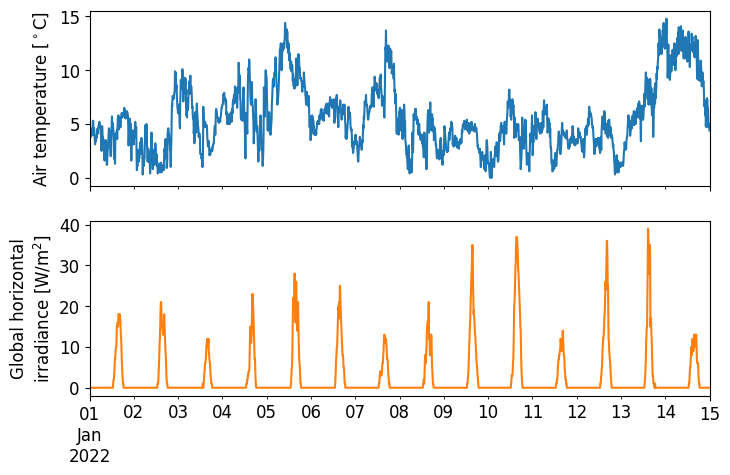

In [16]:
station = '04250'
params = ['wind_speed', 'radia_glob']  # parameters to plot

# Generate plot of data
ax = df[station][params].plot(figsize=(8,5), legend=False, fontsize=12, rot=0, subplots=True)
ax[0].set_ylabel('Air temperature [$^\circ$C]', size=12)
ax[1].set_ylabel('Global horizontal\nirradiance [W/m$^2$]', size=12)
ax[1].set_xlabel('', size=12)